In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import e_pulses
from qspectro2d.visualization import plot_example_evo, plot_el_field, plot_all_pulse_components, plot_pulse_envelopes, plot_e_pulses
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.rwa_utils import get_expect_vals_with_RWA
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.spectroscopy.post_processing import compute_spectra
from plotstyle import init_style, COLORS, LINE_STYLES, save_fig
init_style()

from pathlib import Path
custom_dir = Path("test_Spectroscopy")
custom_dir.mkdir(exist_ok=True)

In [ ]:
from qspectro2d.utils.constants import convert_cm_to_fs
# Parameters for the qubit system
omega0 = 16000      # transition frequency ~16000 cm⁻¹
omega0 = convert_cm_to_fs(omega0)  # convert to rad/fs
print(f"omega0 = {omega0:.2f} rad/fs")
Gamma = 0.05      # homogeneous dephasing rate = 1/10 fs⁻¹
Gamma1 = 1/100    # population decay rate = 1/100 fs⁻¹
t2 = 0.0          # waiting time (set to 0 for simplicity)

# Time grids for t_cohs and t_dets (coherence times)
dt = 0.1          # time step in fs
T_max = 300.0     # max time in fs
n_t = int(T_max / dt) + 1  # number of points
t_cohs = dt * np.arange(0, n_t)
t_dets = dt * np.arange(0, n_t)
T1, T3 = np.meshgrid(t_cohs, t_dets, indexing='ij')  # T1 is (n_t, n_t), etc.

# Individual response functions (time domain)
R1_time = np.exp(-1j * omega0 * T1) * np.exp(-1j * omega0 * T3) * np.exp(- Gamma * T1 - Gamma1 * t2 - Gamma * T3)
R2_time = np.exp(1j * omega0 * T1) * np.exp(-1j * omega0 * T3) * np.exp(- Gamma * T1 - Gamma1 * t2 - Gamma * T3)
R3_time = R2_time  # R3 = R2 for two-level system
R4_time = R1_time  # R4 = R1 for two-level system

# Combined for rephasing and non-rephasing
R_reph_time = R2_time + R3_time
R_nonr_time = R1_time + R4_time

omega0 = 3.01 rad/fs


In [3]:
# --- build uniform phase grid on [0, 2π), endpoint excluded ---
Nphi   = 4
phases = np.linspace(0.0, 2*np.pi, Nphi, endpoint=False)
dphi   = 2*np.pi / Nphi

# --- flatten the (T1,T3) time grids to a single axis ---
R1_flat = R1_time.reshape(-1)  # shape (n_t*n_t,)
R2_flat = R2_time.reshape(-1)
T_flat  = R1_flat.size

# --- synthesize φ1/φ2-resolved dataset P_grid(φ1, φ2, t_flat) ---
P_grid = np.zeros((Nphi, Nphi, T_flat), dtype=complex)
for i, phi1 in enumerate(phases):
    for k, phi2 in enumerate(phases):
        # rephasing term carries (-φ1 + φ2)
        P_grid[i, k, :] += R2_flat * np.exp(1j * (-phi1 + phi2))
        # non-rephasing term carries (+φ1 - φ2)
        P_grid[i, k, :] += R1_flat * np.exp(1j * (+phi1 - phi2))

# --- demodulate (your function) ---
R2_rec_flat = phase_cycle_component(phases, P_grid, lm=(-1, +1))  # rephasing selector
R1_rec_flat = phase_cycle_component(phases, P_grid, lm=(+1, -1))  # non-rephasing selector

# --- normalization: double integral gives (2π)^2 on a match ---
norm = (2*np.pi)**2
R2_rec_flat /= norm
R1_rec_flat /= norm

# --- reshape back to (n_t, n_t) to compare with analytic surfaces ---
R2_rec = R2_rec_flat.reshape(n_t, n_t)
R1_rec = R1_rec_flat.reshape(n_t, n_t)

# --- quick sanity checks ---
err_R2 = np.max(np.abs(R2_rec - R2_time))
err_R1 = np.max(np.abs(R1_rec - R1_time))
print(f"max|R2_rec - R2_time| = {err_R2:.3e}")
print(f"max|R1_rec - R1_time| = {err_R1:.3e}")


max|R2_rec - R2_time| = 4.450e-16
max|R1_rec - R1_time| = 4.475e-16


In [4]:
# Compute spectra using the compute_spectra function with virtual padding
signal_types = ["rephasing", "nonrephasing"]
nu_cohs, nu_dets, datas_nu, out_types = compute_spectra([R_reph_time, R_nonr_time], signal_types, t_det=t_dets, t_coh=t_cohs, pad=4.0)

print(f"Frequency axes: nu_cohs shape {nu_cohs.shape}, nu_dets shape {nu_dets.shape}")
print(f"Output types: {out_types}")
print(f"Spectra shapes: {[d.shape for d in datas_nu]}")

Frequency axes: nu_cohs shape (12004,), nu_dets shape (12004,)
Output types: ['rephasing', 'nonrephasing']
Spectra shapes: [(12004, 12004), (12004, 12004)]


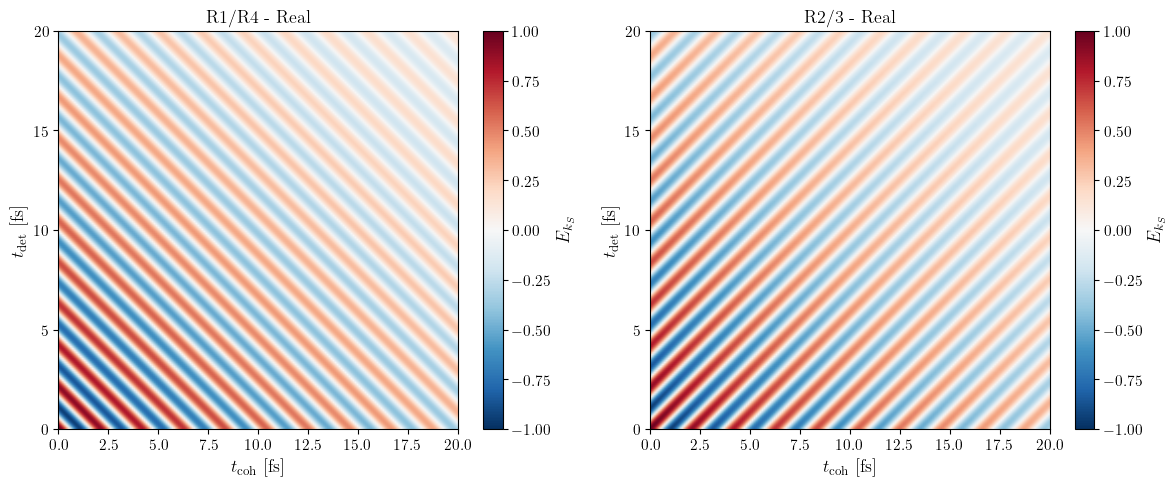

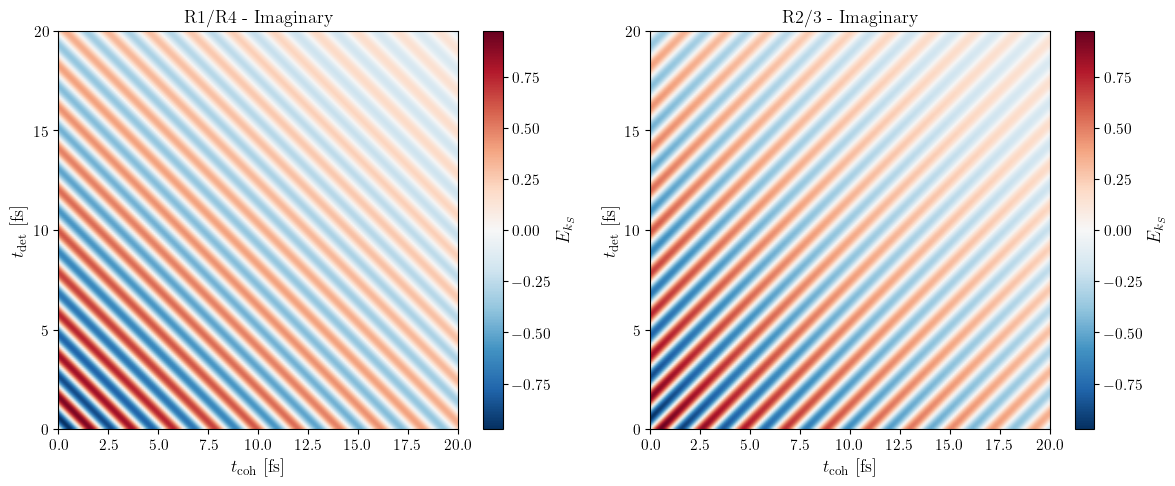

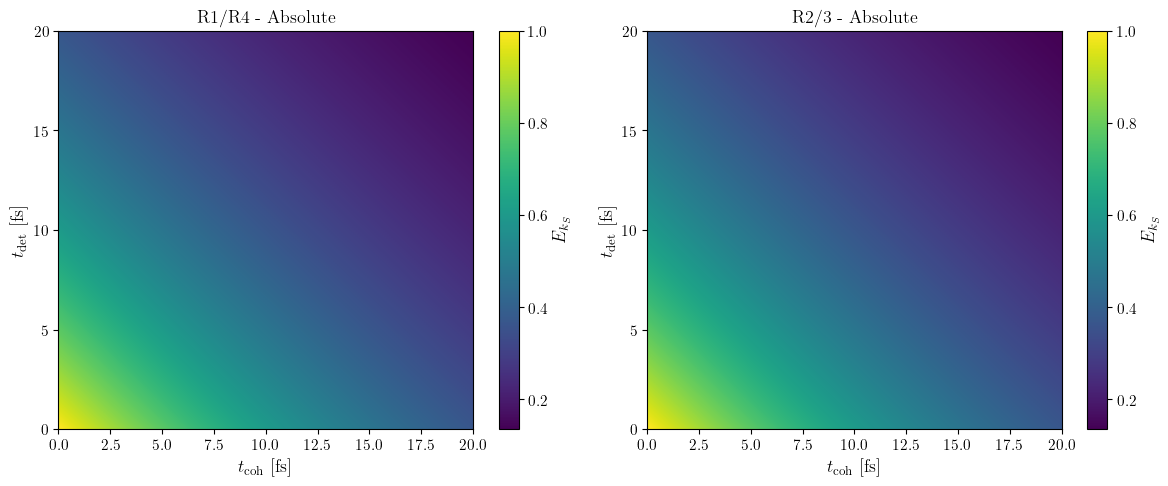

In [5]:
# Plot R1,R2 time domain - Real parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
responses_time = [R1_time, R2_time]
labels = ['R1/R4', 'R2/3']

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="real",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Real")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_real.png")
plt.show()

# Plot R1,R2 time domain - Imaginary parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="img",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Imaginary")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_img.png")
plt.show()

# Plot R1,R2 time domain - Absolute values (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="abs",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_abs.png")
plt.show()

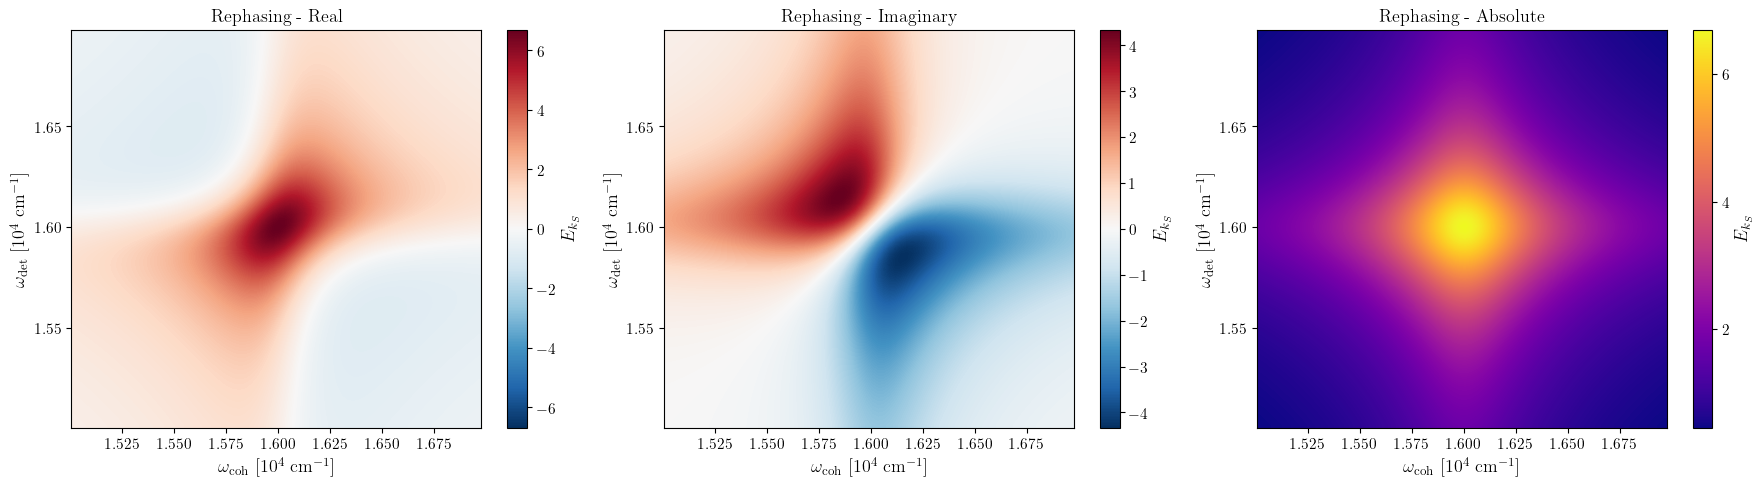

In [6]:
section = (1.5, 1.7)

# Plot rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "rephasing_spectra_combined.png")
plt.show()

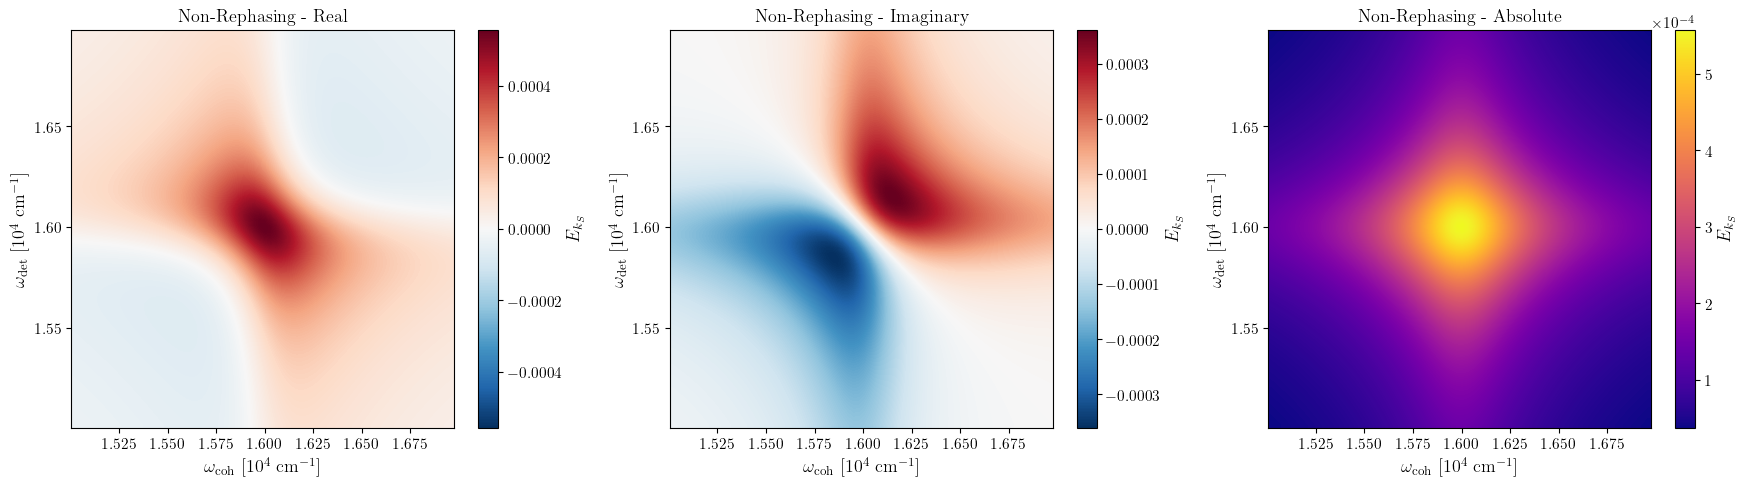

In [7]:
# Plot non-rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Non-Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Non-Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "nonrephasing_spectra_combined.png")
plt.show()

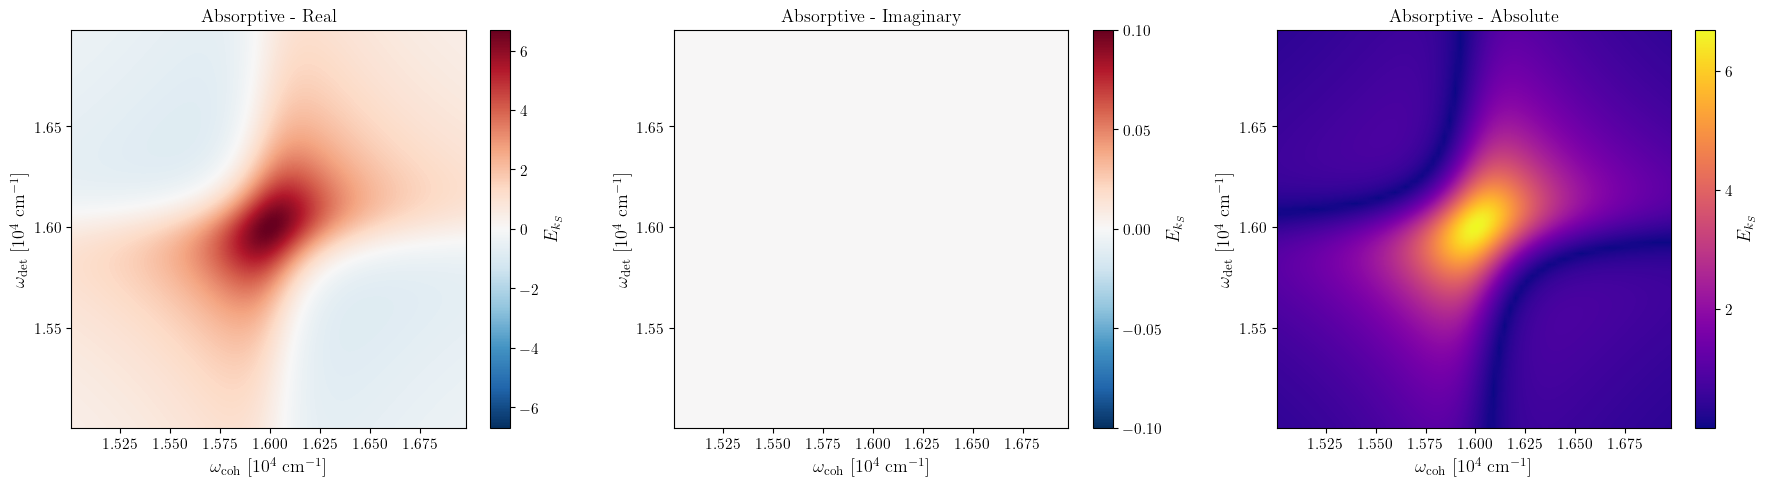

In [8]:
# Compute absorptive spectrum (complex sum)
absorptive = np.real(datas_nu[0] + datas_nu[1])

# Plot absorptive spectrum: real, imag, abs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Absorptive - Real")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Absorptive - Imaginary")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Absorptive - Absolute")
plt.tight_layout()
save_fig(fig, custom_dir / "absorptive_section.png")
plt.show()

In [12]:
# Compute additional phase cycled components
lm_list = [(0,0), (1,1), (-1,1), (1,-1)]
phase_cycled = {}
for lm in lm_list:
    pc_flat = phase_cycle_component(phases, P_grid, lm=lm)
    pc_flat /= norm  # normalize
    pc_reshaped = pc_flat.reshape(n_t, n_t)
    phase_cycled[lm] = pc_reshaped

In [11]:
print("Starting phase cycled computation")

Starting phase cycled computation


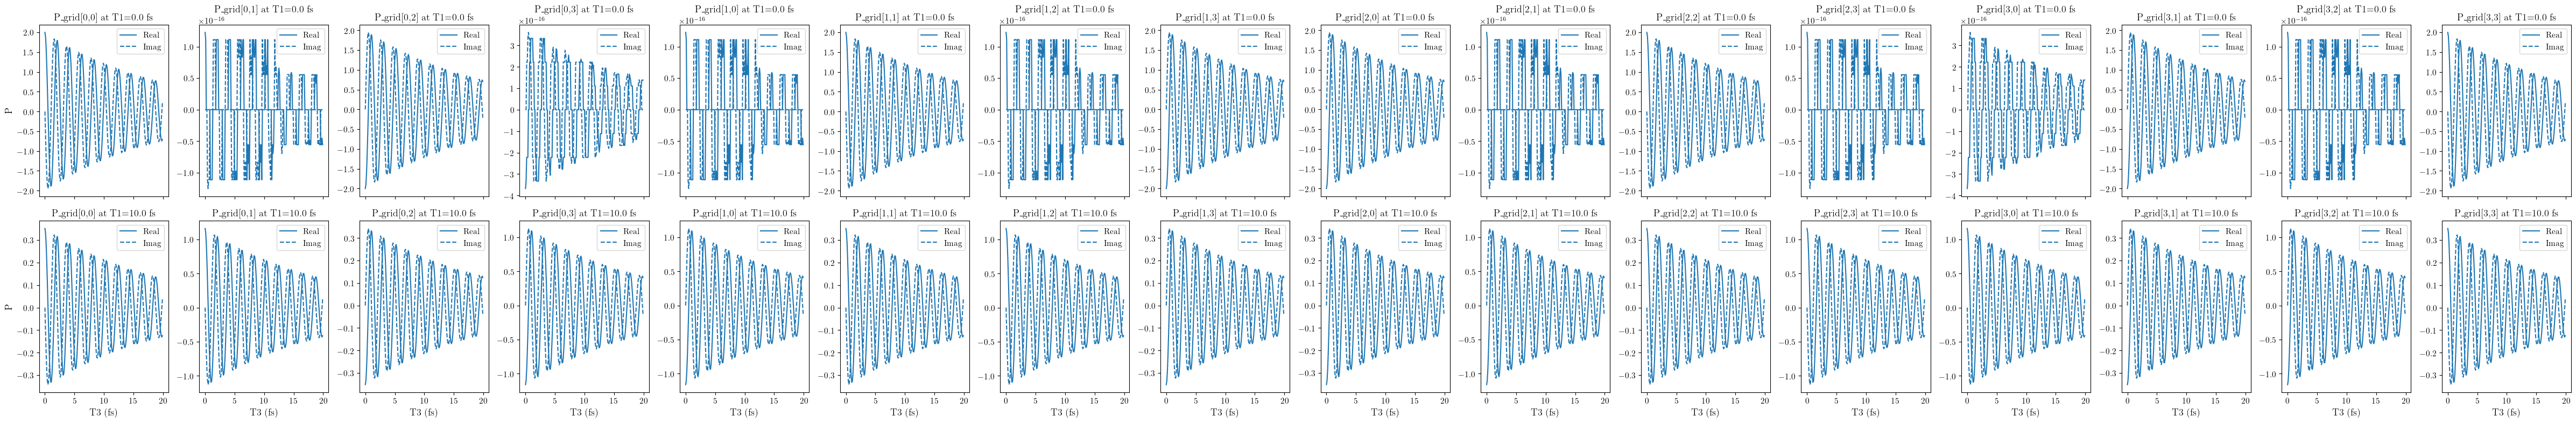

In [19]:
# Plot some P_grid data for fixed T1, varying T3
T1_indices = [0, 100]  # corresponding to t_cohs[0]=0 fs, t_cohs[100]=10 fs
phi_pairs = [(i, j) for i in range(Nphi) for j in range(Nphi)]

# Select small time section: 0 to 20 fs (200 points)
time_slice = slice(0, 200)
t_dets_small = t_dets[time_slice]

fig, axes = plt.subplots(len(T1_indices), len(phi_pairs), figsize=(3 * len(phi_pairs), 8), sharex=True)
for i, T1_idx in enumerate(T1_indices):
    for j, (phi1_idx, phi2_idx) in enumerate(phi_pairs):
        ax = axes[i, j]
        P_reshaped = P_grid[phi1_idx, phi2_idx, :].reshape(n_t, n_t)
        P_slice = P_reshaped[T1_idx, time_slice]  # fixed T1, varying T3, small section
        ax.plot(t_dets_small, np.real(P_slice), label='Real')
        ax.plot(t_dets_small, np.imag(P_slice), label='Imag')
        ax.set_title(f'P_grid[{phi1_idx},{phi2_idx}] at T1={t_cohs[T1_idx]:.1f} fs')
        ax.legend()
        if i == len(T1_indices)-1:
            ax.set_xlabel('T3 (fs)')
        if j == 0:
            ax.set_ylabel('P')

plt.tight_layout()
plt.show()

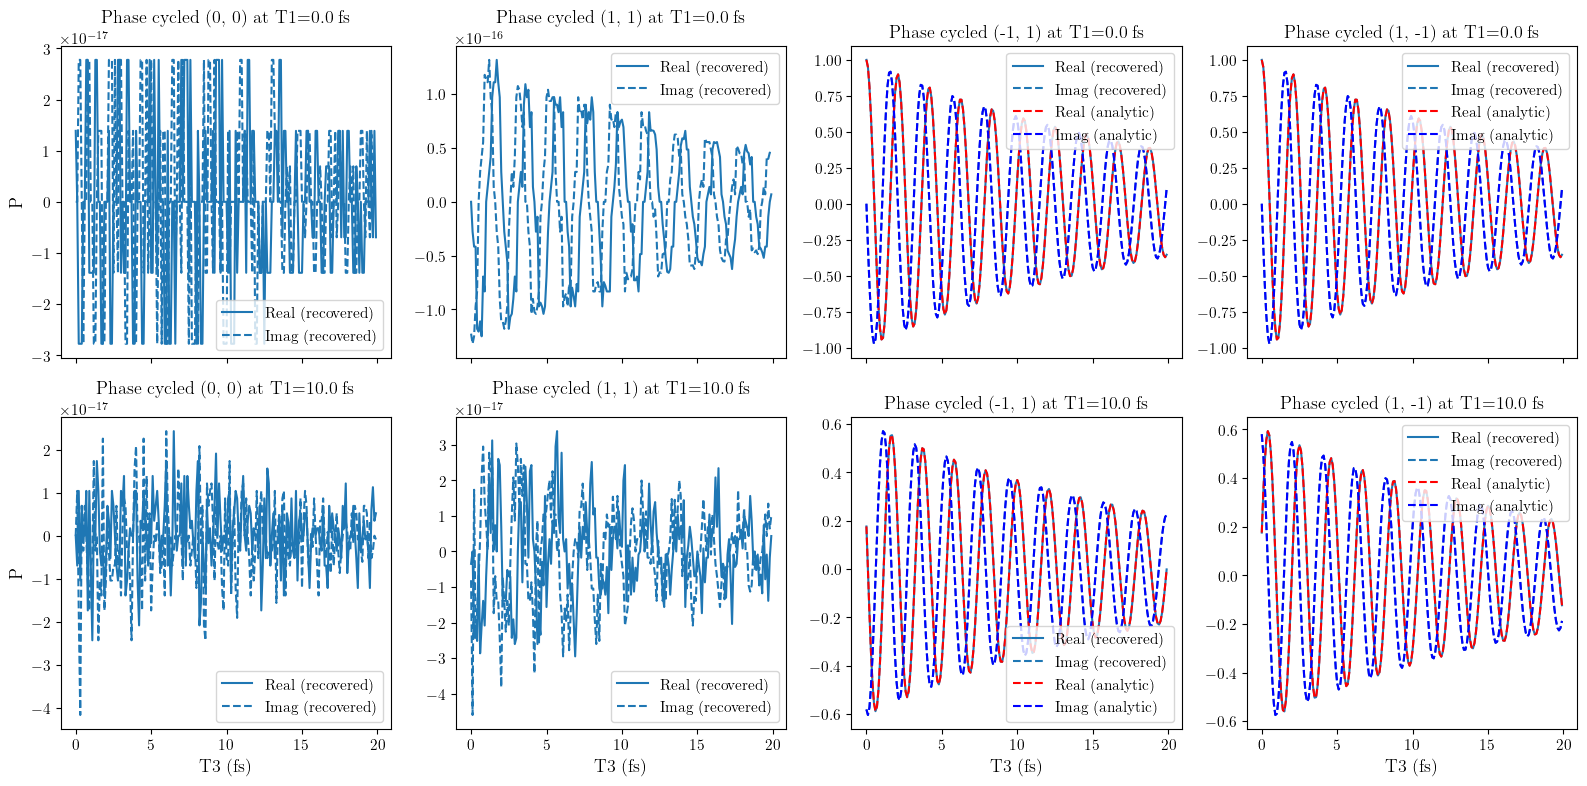

In [17]:
# Plot phase cycled components for fixed T1, varying T3 (small time section)
# Select small time section: 0 to 20 fs (200 points)
time_slice = slice(0, 200)
t_dets_small = t_dets[time_slice]

fig, axes = plt.subplots(len(T1_indices), len(lm_list), figsize=(16, 8), sharex=True)
for i, T1_idx in enumerate(T1_indices):
    for j, lm in enumerate(lm_list):
        ax = axes[i, j]
        pc = phase_cycled[lm]
        pc_slice = pc[T1_idx, time_slice]  # fixed T1, varying T3, small section
        ax.plot(t_dets_small, np.real(pc_slice), label='Real (recovered)')
        ax.plot(t_dets_small, np.imag(pc_slice), label='Imag (recovered)')
        # Add analytic if applicable
        if lm == (1, -1):
            analytic_slice = R1_time[T1_idx, time_slice]
            ax.plot(t_dets_small, np.real(analytic_slice), '--', label='Real (analytic)', color='red')
            ax.plot(t_dets_small, np.imag(analytic_slice), '--', label='Imag (analytic)', color='blue')
        elif lm == (-1, 1):
            analytic_slice = R2_time[T1_idx, time_slice]
            ax.plot(t_dets_small, np.real(analytic_slice), '--', label='Real (analytic)', color='red')
            ax.plot(t_dets_small, np.imag(analytic_slice), '--', label='Imag (analytic)', color='blue')
        ax.set_title(f'Phase cycled {lm} at T1={t_cohs[T1_idx]:.1f} fs')
        ax.legend()
        if i == len(T1_indices)-1:
            ax.set_xlabel('T3 (fs)')
        if j == 0:
            ax.set_ylabel('P')

plt.tight_layout()
plt.show()